In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import HTML
from scipy.io import loadmat
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import seaborn as sn
from mpl_toolkits import mplot3d
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
import random
import multiprocessing
from joblib import Parallel, delayed
import os
from pathlib import Path
NumThread=(multiprocessing.cpu_count()-1)*2
import pickle
from joblib import Parallel, delayed
from multiprocessing import cpu_count, Pool
import glob
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.ndimage.filters import convolve
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler


/tmp/ipykernel_528126/1211680657.py:25: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


functions:

In [2]:
def load(mat_file='', channels=[16, 17, 18]):
    mat = loadmat(mat_file)
    # Extract the saccade_data cell array. This will be a structured numpy array.
    saccade_data = mat[list(mat.keys())[-1]][0]
    
    # Selectively return the channels of interest, omitting all others
    extracted_saccades = []
    for saccade in saccade_data:
        channel_sacs = []
        for channel in channels:
            channel_sacs.append(np.array(saccade[channel]))
        # Taking the mean over the selected channels
        mean_channel_sacs = np.mean(channel_sacs, axis=0).tolist()
        # Wrapping the mean in a list to maintain the 2D structure
        extracted_saccades.append([mean_channel_sacs])
    return extracted_saccades



def normalize(saccades):
    for i in range(len(saccades)):
        for j in range(len(saccades[i])):
            saccades[i][j] = (saccades[i][j]-np.mean(saccades[i][j]))/np.std(saccades[i][j])
    return saccades

def car_to_polar(saccades):
    for i in range(len(saccades)):
        x=saccades[i][0]
        y=saccades[i][1]
        rho=np.sqrt(x**2+y**2)
        phi=np.arctan2(y,x)
        saccades[i]=np.array([rho,phi])
    return saccades


def normalize_length(saccade, length=42):   #but based on the histogram, 42 seems to be more correct, check with Austin
    saccade = np.asarray(saccade) 
    x = np.linspace(0, 1, num=saccade.shape[0])
    x_new = np.linspace(0, 1, num=length)
    f = interp1d(x, saccade)
    return f(x_new)

In [3]:
sac_pos = load('/mnt/home/mplomecka/saccades/data/postprocessing/data/filteredData_proright_young.mat')


martyna_indexes = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/martyna_indexes.npy')
print("Shape of martyna_indexes:", martyna_indexes.shape)
#first few entries 
print("First few entries:", martyna_indexes[:5])


martyna_results = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/martyna_results.npy', allow_pickle=True)
for key, value in martyna_results.item().items():
    print(f"Shape of {key}:", np.shape(value))

Shape of martyna_indexes: (1000,)
First few entries: [4218 1371 2660 2688 1615]
Shape of lyv_vc: (3, 3, 42000)
Shape of les_vc: (42000, 3)
Shape of vc: (3, 42000)
Shape of ly_ids: (42000,)


In [4]:
shapes = [np.shape(sac) for sac in sac_pos]
unique_shapes = set(shapes)
print("Number of saccades:", len(sac_pos))
print("Unique shapes within the loaded saccades data:", unique_shapes)

Number of saccades: 5006
Unique shapes within the loaded saccades data: {(1, 37), (1, 34), (1, 40), (1, 46), (1, 43), (1, 49), (1, 33), (1, 39), (1, 36), (1, 42), (1, 45), (1, 51), (1, 48), (1, 35), (1, 38), (1, 44), (1, 41), (1, 47), (1, 50)}


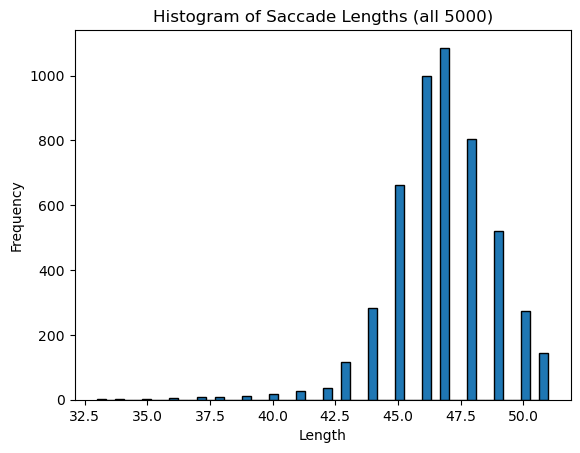

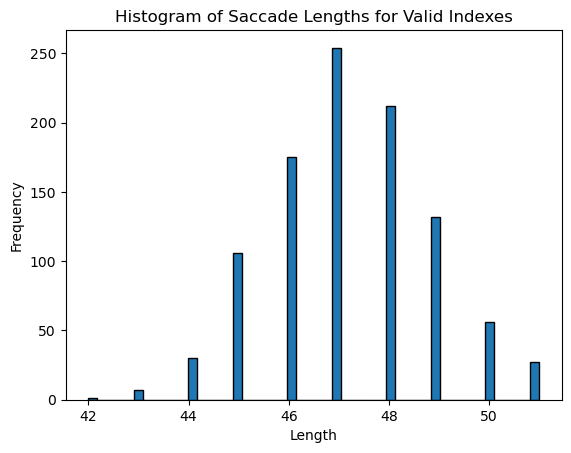

1000


In [5]:
# First get the list inside each sac, then the length of the list
lengths = [len(sac[0]) for sac in sac_pos]
plt.hist(lengths, bins=50, edgecolor='black') 
plt.title('Histogram of Saccade Lengths (all 5000)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Extract the lengths of the saccades from the length of the list for the given indexes
lengths = [len(sac_pos[idx][0]) for idx in martyna_indexes]

plt.hist(lengths, bins=50, edgecolor='black') 
plt.title('Histogram of Saccade Lengths for Valid Indexes')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()


print(len(lengths))


In [6]:
# take the saccades based on specific indexes (that are present in the martyna_indexes table)
selected_saccades = [sac_pos[idx][0] for idx in martyna_indexes]
normalized_saccades = [normalize_length(sac) for sac in selected_saccades]
len(selected_saccades) #should be 1000

1000

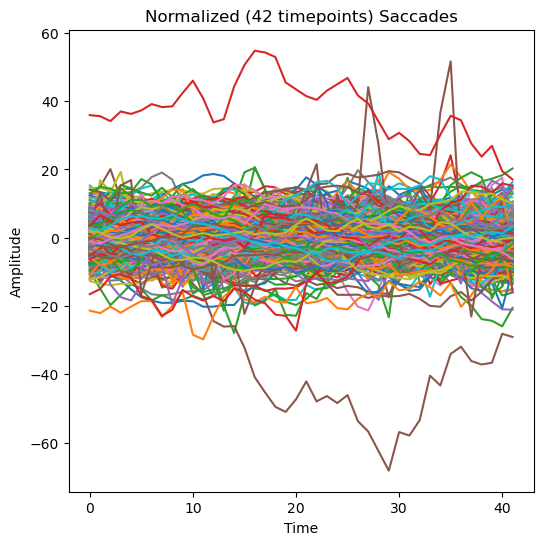

Number of saccades after filtering: 732
Filtered indexes: [1371, 2660, 2688, 110, 2973, 969, 2166, 865, 4143, 937, 493, 470, 4802, 2006, 3860, 1854, 4850, 3930, 1631, 2002, 2381, 4044, 1911, 4873, 2809, 4867, 850, 398, 4839, 294, 981, 420, 3351, 4530, 4001, 4927, 2684, 1966, 1331, 3615, 3383, 1521, 2879, 423, 1181, 4238, 3149, 2910, 2467, 2067, 4719, 3129, 2394, 3497, 3956, 3214, 985, 4064, 1345, 2388, 584, 3590, 311, 2044, 702, 3634, 480, 563, 395, 2062, 1626, 2124, 4688, 1654, 42, 2345, 975, 4472, 3116, 1366, 2385, 4757, 2439, 4854, 3310, 2058, 4740, 123, 1899, 3407, 2425, 2426, 4526, 2405, 461, 674, 1367, 4842, 978, 2437, 4875, 701, 1767, 2431, 3406, 4072, 148, 1901, 3356, 490, 1419, 3371, 16, 1885, 3467, 4812, 267, 1559, 4735, 1612, 1825, 4211, 3625, 3976, 1003, 2925, 2020, 4568, 1687, 2723, 1389, 3366, 4774, 3594, 946, 892, 4934, 4020, 446, 1468, 3290, 3385, 2248, 670, 3585, 3869, 4258, 4874, 1416, 1026, 2247, 2414, 10, 1338, 2402, 3776, 4851, 4574, 528, 4825, 412, 2013, 2911, 176

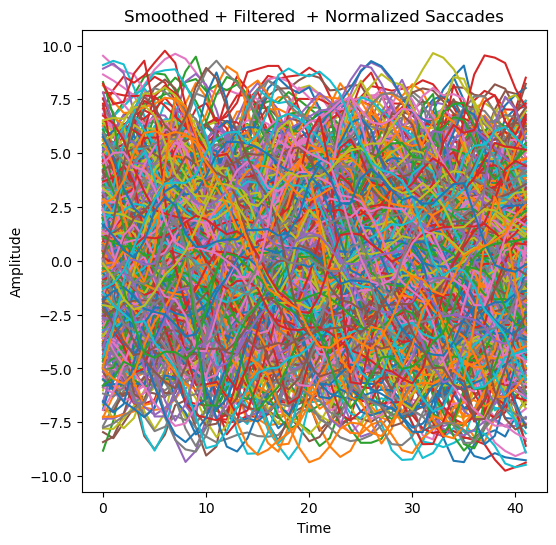

In [7]:
plt.figure(figsize=(6, 6))

for sac in normalized_saccades:
    plt.plot(sac)

plt.title('Normalized (42 timepoints) Saccades')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


def smooth_trajectory(trajectory, window_size=3):
    window = np.ones(window_size) / window_size
    return convolve(trajectory, window, mode='reflect')

window_size = 3 #when window_size ==1, no smoothing

# Filtering the saccades +  keeping the original indexes
filtered_saccades = []
filtered_indexes = []
for sac, idx in zip(normalized_saccades, martyna_indexes):
    if np.all(np.abs(sac) <= 10):
        filtered_saccades.append(smooth_trajectory(sac, window_size))
        filtered_indexes.append(idx)

print(f"Number of saccades after filtering: {len(filtered_saccades)}")
print("Filtered indexes:", filtered_indexes)

# Plotting only filtered saccades
plt.figure(figsize=(6, 6))
for sac in filtered_saccades:
    plt.plot(sac)

plt.title('Smoothed + Filtered  + Normalized Saccades')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


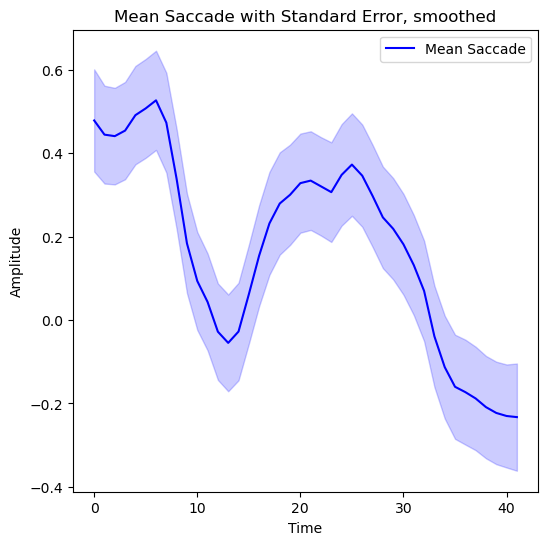

In [8]:

mean_saccade = np.mean(filtered_saccades, axis=0)
standard_error = np.std(filtered_saccades, axis=0) / np.sqrt(len(filtered_saccades))

plt.figure(figsize=(6, 6))
plt.plot(mean_saccade, label='Mean Saccade', color='blue')

# Adding the "sausage" or shaded region for the standard error
plt.fill_between(range(len(mean_saccade)), mean_saccade - standard_error, mean_saccade + standard_error, color='blue', alpha=0.2)

plt.title('Mean Saccade with Standard Error, smoothed')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


#### iterate through saccades_lyv_vc and martyna_indexes simultaneously, pairing the corresponding elements together without using the values inside martyna_indexes as indices for saccades_lyv_vc:

In [9]:
martyna_indexes = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/martyna_indexes.npy')
martyna_results = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/martyna_results.npy', allow_pickle=True)
lyv_vc = martyna_results.item()['lyv_vc']
saccades_lyv_vc = [lyv_vc[:, :, i*42:(i+1)*42] for i in range(1000)]
selected_lyv_vc = [value for value, idx in zip(saccades_lyv_vc, martyna_indexes)]


In [10]:
selected_lyv_vc_array = np.array(selected_lyv_vc)
print("Dimensions of selected_lyv_vc:", selected_lyv_vc_array.shape)

Dimensions of selected_lyv_vc: (1000, 3, 3, 42)


Number of trajectories: 1000
Dimensions of selected_lyv_vc_array: (1000, 3, 3, 42)


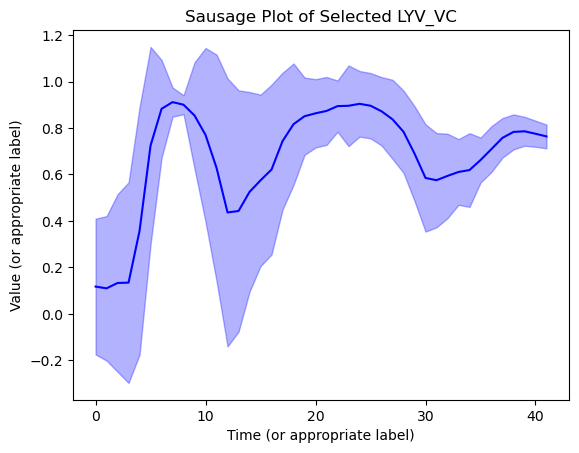

In [11]:
data_slice = selected_lyv_vc_array[:, 1, 1, :]
mean_values = np.mean(data_slice, axis=0)
std_values = np.std(data_slice, axis=0)

time_axis = np.arange(42)  

print("Number of trajectories:", data_slice.shape[0])
print("Dimensions of selected_lyv_vc_array:", selected_lyv_vc_array.shape)

# Plot the mean
plt.plot(time_axis, mean_values, color='blue')
# sausage
plt.fill_between(time_axis, mean_values - std_values, mean_values + std_values, color='blue', alpha=0.3)

plt.title('Sausage Plot of Selected LYV_VC')
plt.xlabel('Time (or appropriate label)') 
plt.ylabel('Value (or appropriate label)')
plt.show()



filter further to have the same trajec

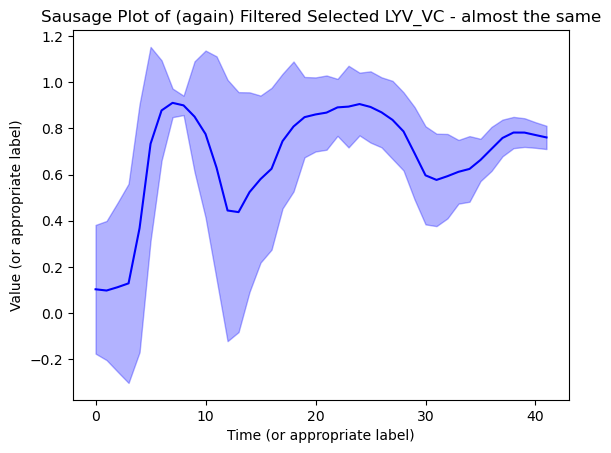

Number of trajectories: 732


In [12]:
filtered_lyv_vc = [selected_lyv_vc[i] for i in range(len(filtered_indexes))]

filtered_lyv_vc_array = np.array(filtered_lyv_vc)
data_slice = filtered_lyv_vc_array[:, 1, 1, :]

# Compute mean and standard deviation
mean_values = np.mean(data_slice, axis=0)
std_values = np.std(data_slice, axis=0)

time_axis = np.arange(42)  

# Plot the mean
plt.plot(time_axis, mean_values, color='blue')

# Fill between for the standard deviation
plt.fill_between(time_axis, mean_values - std_values, mean_values + std_values, color='blue', alpha=0.3)

plt.title('Sausage Plot of (again) Filtered Selected LYV_VC - almost the same')
plt.xlabel('Time (or appropriate label)') 
plt.ylabel('Value (or appropriate label)')
plt.show()

print("Number of trajectories:", data_slice.shape[0])


In [13]:
print("Dimensions of filtered_lyv_vc_array:", filtered_lyv_vc_array.shape)

Dimensions of filtered_lyv_vc_array: (732, 3, 3, 42)


#### Correlation

In [14]:
print("Shape of data_slice:", data_slice.shape)
filtered_saccades_array = np.array(filtered_saccades)
print("Shape of filtered_saccades:", filtered_saccades_array.shape)


Shape of data_slice: (732, 42)
Shape of filtered_saccades: (732, 42)


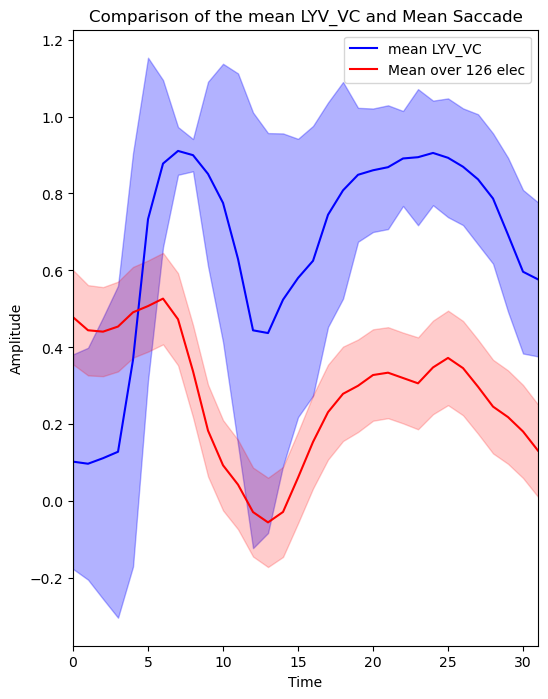

Number of LYV_VCSs: 732


In [15]:
plt.figure(figsize=(6, 8))

# First trajectory
filtered_lyv_vc = [selected_lyv_vc[i] for i in range(len(filtered_indexes))]
filtered_lyv_vc_array = np.array(filtered_lyv_vc)
data_slice = filtered_lyv_vc_array[:, 1, 1, :]
mean_values = np.mean(data_slice, axis=0)[:32]
std_values = np.std(data_slice, axis=0)[:32]
time_axis = np.arange(32)
plt.plot(time_axis, mean_values, color='blue', label='mean LYV_VC')
plt.fill_between(time_axis, mean_values - std_values, mean_values + std_values, color='blue', alpha=0.3)

# Second trajectory
mean_saccade = np.mean(filtered_saccades, axis=0)[:32]
standard_error = np.std(filtered_saccades, axis=0)[:32] / np.sqrt(len(filtered_saccades))
plt.plot(time_axis, mean_saccade, label='Mean over 126 elec', color='red')
plt.fill_between(time_axis, mean_saccade - standard_error, mean_saccade + standard_error, color='red', alpha=0.2)

plt.title('Comparison of the mean LYV_VC and Mean Saccade')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim(0, 31) 
plt.legend()
plt.show()

print("Number of LYV_VCSs:", data_slice.shape[0])


### normalizing the time series to the same scale by standardizing them (subtracting the mean and dividing by the standard deviation) 

In [16]:
# Standardize both time series
data_slice_normalized = zscore(data_slice, axis=0)
filtered_saccades_normalized = zscore(filtered_saccades_array, axis=0)

correlations_normalized = [pearsonr(data_slice_normalized[:, i], filtered_saccades_normalized[:, i])[0] for i in range(data_slice.shape[1])]

plt.plot(correlations_normalized)
plt.title('Correlations between Normalized Data Slice and Filtered Saccades')
plt.xlabel('Time Point')
plt.ylabel('Correlation')
plt.show()


NameError: name 'zscore' is not defined

### calculating the correlation over moving time windows. 

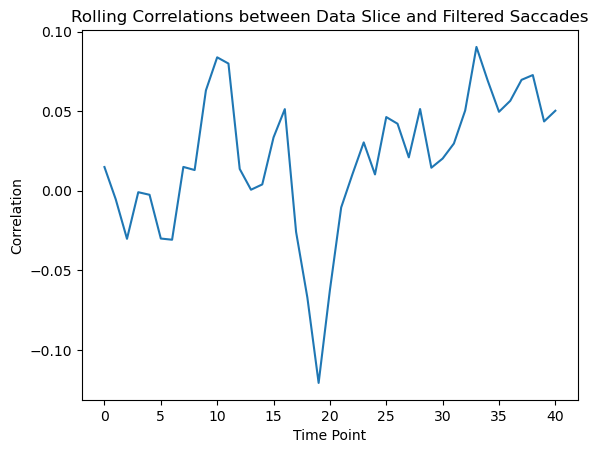

In [ ]:
#rolling corr
def rolling_correlation(time_series1, time_series2, window_size):
    correlations = []
    for i in range(time_series1.shape[1] - window_size + 1):
        window_ts1 = time_series1[:, i:i+window_size]
        window_ts2 = time_series2[:, i:i+window_size]
        corr = pearsonr(window_ts1.mean(axis=1), window_ts2.mean(axis=1))[0]
        correlations.append(corr)
    return correlations


window_size = 2
correlations_windowed = rolling_correlation(data_slice, filtered_saccades_array, window_size)

plt.plot(correlations_windowed)
plt.title('Rolling Correlations between Data Slice and Filtered Saccades')
plt.xlabel('Time Point')
plt.ylabel('Correlation')
plt.show()


### normalizing by rescaling them to a common range.

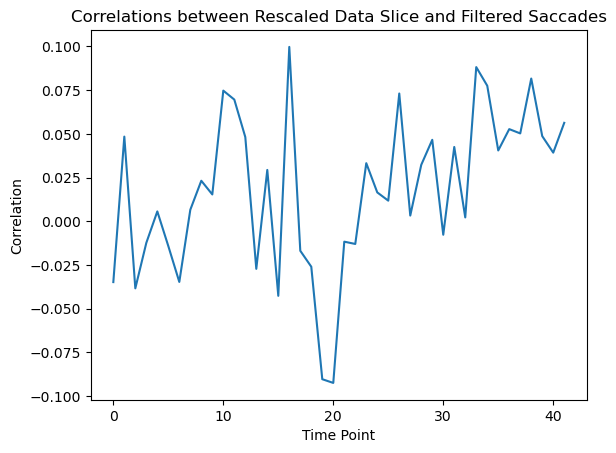

In [ ]:
scaler = MinMaxScaler()

# Concat. the data for joint scaling
joint_data = np.concatenate((data_slice, filtered_saccades_array), axis=1)

# Scale the data
scaled_data = scaler.fit_transform(joint_data)

# Split the data back into the two org arrays
scaled_data_slice = scaled_data[:, :data_slice.shape[1]]
scaled_filtered_saccades_array = scaled_data[:, data_slice.shape[1]:]

correlations = []
for i in range(scaled_data_slice.shape[1]):
    corr, _ = pearsonr(scaled_data_slice[:, i], scaled_filtered_saccades_array[:, i])
    correlations.append(corr)

plt.plot(correlations)
plt.title('Correlations between Rescaled Data Slice and Filtered Saccades')
plt.xlabel('Time Point')
plt.ylabel('Correlation')
plt.show()
